In [29]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
# Read in the trip summary data
file_path = '../data/trip_summary_201901.csv'
trips = pd.read_csv(file_path)
trips

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count
0,2019-01-01,0,109,17th St at Valencia St,23.0,True,141,Valencia St at Cesar Chavez St,19.0,True,37.763316,-122.421904,37.747998,-122.420219,390,6.500000,1,1,0
1,2019-01-01,0,109,17th St at Valencia St,23.0,True,91,Berry St at King St,23.0,True,37.763316,-122.421904,37.771762,-122.398438,780,13.000000,1,1,0
2,2019-01-01,0,118,Eureka Valley Recreation Center,19.0,True,126,Esprit Park,31.0,True,37.759177,-122.436943,37.761634,-122.390648,1306,21.766667,1,1,0
3,2019-01-01,0,119,18th St at Noe St,15.0,True,98,Valencia St at 16th St,23.0,True,37.761047,-122.432642,37.765052,-122.421866,422,7.033333,1,1,0
4,2019-01-01,0,120,Mission Dolores Park,27.0,True,98,Valencia St at 16th St,23.0,True,37.761420,-122.426435,37.765052,-122.421866,277,4.616667,1,1,0
5,2019-01-01,0,121,Mission Playground,23.0,True,144,Precita Park,15.0,True,37.759210,-122.421339,37.747300,-122.411403,350,5.833333,1,0,1
6,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,377,Fell St at Stanyan St,19.0,True,37.794231,-122.402923,37.771917,-122.453704,3421,57.016667,2,2,0
7,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,62,Victoria Manalo Draves Park,15.0,True,37.794231,-122.402923,37.777791,-122.406432,930,15.500000,1,0,1
8,2019-01-01,0,138,Jersey St at Church St,19.0,True,145,29th St at Church St,15.0,True,37.750900,-122.427411,37.743684,-122.426806,135,2.250000,1,1,0
9,2019-01-01,0,15,San Francisco Ferry Building (Harry Bridges Pl...,38.0,True,34,Father Alfred E Boeddeker Park,23.0,True,37.795392,-122.394203,37.783988,-122.412408,1325,22.083333,2,2,0


In [27]:
# Feature engineering
trips['start_dow'] = trips['start_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')).dt.weekday_name
trips

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,start_dow
0,2019-01-01,0,109,17th St at Valencia St,23.0,True,141,Valencia St at Cesar Chavez St,19.0,True,37.763316,-122.421904,37.747998,-122.420219,390,6.500000,1,1,0,Tuesday
1,2019-01-01,0,109,17th St at Valencia St,23.0,True,91,Berry St at King St,23.0,True,37.763316,-122.421904,37.771762,-122.398438,780,13.000000,1,1,0,Tuesday
2,2019-01-01,0,118,Eureka Valley Recreation Center,19.0,True,126,Esprit Park,31.0,True,37.759177,-122.436943,37.761634,-122.390648,1306,21.766667,1,1,0,Tuesday
3,2019-01-01,0,119,18th St at Noe St,15.0,True,98,Valencia St at 16th St,23.0,True,37.761047,-122.432642,37.765052,-122.421866,422,7.033333,1,1,0,Tuesday
4,2019-01-01,0,120,Mission Dolores Park,27.0,True,98,Valencia St at 16th St,23.0,True,37.761420,-122.426435,37.765052,-122.421866,277,4.616667,1,1,0,Tuesday
5,2019-01-01,0,121,Mission Playground,23.0,True,144,Precita Park,15.0,True,37.759210,-122.421339,37.747300,-122.411403,350,5.833333,1,0,1,Tuesday
6,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,377,Fell St at Stanyan St,19.0,True,37.794231,-122.402923,37.771917,-122.453704,3421,57.016667,2,2,0,Tuesday
7,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,62,Victoria Manalo Draves Park,15.0,True,37.794231,-122.402923,37.777791,-122.406432,930,15.500000,1,0,1,Tuesday
8,2019-01-01,0,138,Jersey St at Church St,19.0,True,145,29th St at Church St,15.0,True,37.750900,-122.427411,37.743684,-122.426806,135,2.250000,1,1,0,Tuesday
9,2019-01-01,0,15,San Francisco Ferry Building (Harry Bridges Pl...,38.0,True,34,Father Alfred E Boeddeker Park,23.0,True,37.795392,-122.394203,37.783988,-122.412408,1325,22.083333,2,2,0,Tuesday


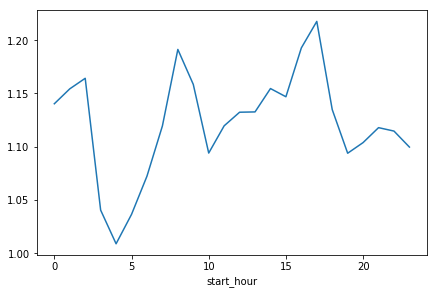

In [32]:
# Plot trip counts by start_hour to check if timezone is correct

# To print pyplot output inline in the notebook withput calling plt.show()
%matplotlib inline

# Increase standard plot size
plt.rcParams['figure.figsize'] = (7, 4.5)

trips_by_hour = trips.groupby('start_hour')['trip_count'].mean()
trips_by_hour.plot()

# Comment: we can see that the peaks in activity happen in the morning and late afternoon.
# This indicates that the timezone of the datetimes are in PST.

In [ ]:
# Split data into train and test


In [ ]:
# Model training and prediction
from sklearn.linear_model import LinearRegression
>>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_ 
3.0000...
>>> reg.predict(np.array([[3, 5]]))
array([16.])

In [ ]:
# Model validation